In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import mglearn
import warnings

warnings.filterwarnings('ignore') 
plt.style.use('classic')

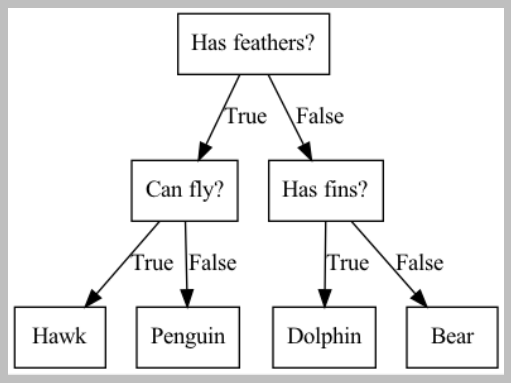

In [19]:
mglearn.plots.plot_animal_tree()

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

def showShape(X,y) :
    print('X shape : ', X.shape)
    print('y shape : ', y.shape)

cancer = load_breast_cancer()
showShape(cancer.data, cancer.target)
print("target : ", np.unique(cancer.target))




X shape :  (569, 30)
y shape :  (569,)
target :  [0 1]


In [21]:
# DecisionTreeClassifier에 매개변수를 따로 할당하지 않으면
# 모든 리프노드가 순수노드가 될 때까지 학습한다.

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    stratify= cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state = 0).fit(X_train, y_train)

print(f"train score : {tree.score(X_train, y_train):0.4f}")
print(f"test score : {tree.score(X_test, y_test):0.4f}")

train score : 1.0000
test score : 0.9371


In [22]:
# 최대 깊이를 설정하여 복잡도를 제어한다.

tree = DecisionTreeClassifier(max_depth=4, random_state = 0).fit(X_train, y_train)

print(f"train score : {tree.score(X_train, y_train):0.4f}")
print(f"test score : {tree.score(X_test, y_test):0.4f}")


train score : 0.9883
test score : 0.9510


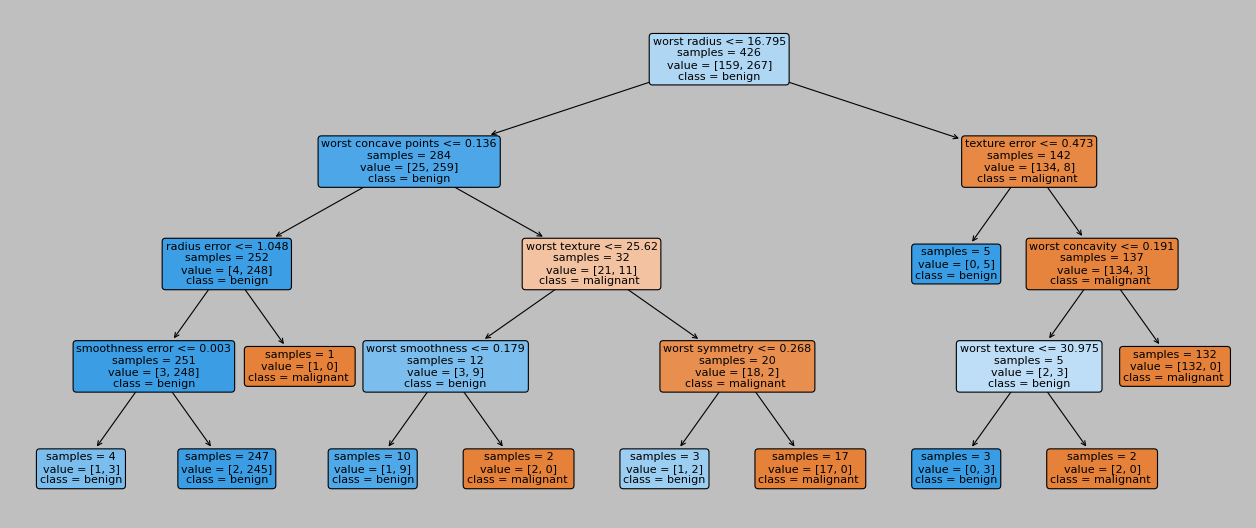

In [23]:
from sklearn.tree import plot_tree
plt.figure(figsize = (20,8))
plot_tree(tree, class_names = ['malignant ', 'benign'], feature_names=cancer.feature_names,
          impurity = False, filled = True, rounded=True, fontsize=10)
plt.show()

In [24]:
print("특성 중요도 :\n", tree.feature_importances_)

특성 중요도 :
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


#### feature importance가 낮다고 하여 이 특성이 꼭 유효하지 않은 것은 아님
#### 단지 결정 트리가 해당 특성을 선택하지 않았을 뿐이고, 다른 특성이 동일한 정보를 지니고 있어서일 수 있다.

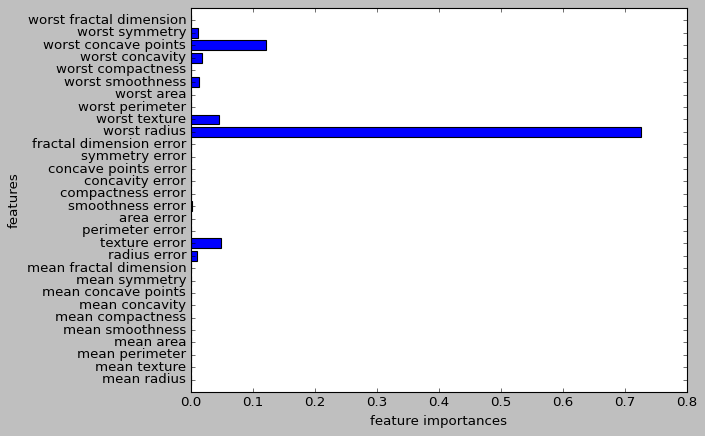

In [25]:
def plot_feature_importances_cancer(model) :
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("feature importances")
    plt.ylabel("features")
    plt.ylim(-1,n_features)
plot_feature_importances_cancer(tree)

### 트리기반 회귀 모델을 사용시 주의사항
#### 본래 데이터의 범위를 넘어가는 값에 대해서는 예측할 수 없음 

In [26]:
import os

ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))
ram_prices.head()

,Unnamed: 0,date,price
0,0,1957.0,411041792.0
1,1,1959.0,67947725.0
2,2,1960.0,5242880.0
3,3,1965.0,2642412.0
4,4,1970.0,734003.0


Text(0, 0.5, 'price')

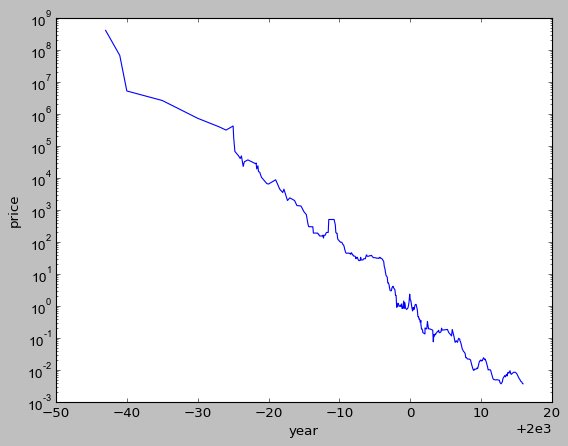

In [27]:

plt.yticks(fontname = 'Arial')
plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("year")
plt.ylabel("price")

In [28]:
# decision tree는 feature scale 에 무관하지만 linear 은 feature scale을 조정해줘야한다.
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date.to_numpy().reshape(-1,1)
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_leg = LinearRegression().fit(X_train, y_train)

X_all = ram_prices.date.to_numpy().reshape(-1,1)

pred_tree = tree.predict(X_all)
pred_lr = linear_leg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

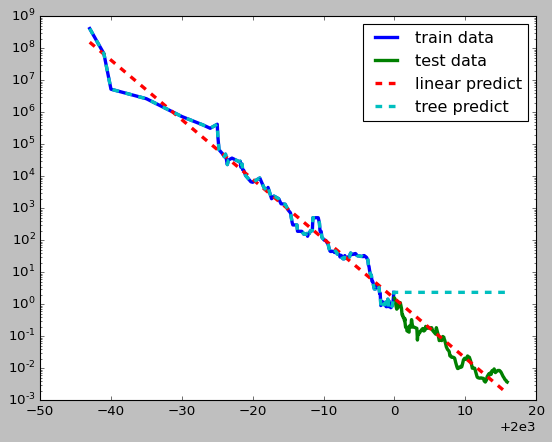

In [29]:
plt.semilogy(data_train.date, data_train.price, label = 'train data', linewidth = 3)
plt.semilogy(data_test.date, data_test.price, label = 'test data',linewidth = 3)
plt.semilogy(X_all, price_lr, label = 'linear predict',linewidth = 3, linestyle = '--')
plt.semilogy(X_all, price_tree, label = 'tree predict',linewidth = 3, linestyle = '--')
plt.legend()

# 랜덤 포레스트

#### 데이터에서 부트스트랩 샘플을 생성한다. 
- 생성되는 샘플의 개수 = n_estimators (이는 클수록 좋다.)
- 이 샘플의 개수는 데이터의 개수와 같고 복원추출하여 생성한다.
#### 각각의 샘플에서 결정트리에서 사용할 특성을 정한다. 
- 사용할 특성의 개수 = max_features (분류에서는 sqrt(n_features), 회귀에서는 n_features 가 기본값이다.)
- 사용할 특성의 개수를 늘릴 수록 무작위성이 줄어든다.

#### 수많은 결정트리를 만든다.
- 회귀의 경우 결정트리 예측값을 평균내어 예측한다.
- 분류의 경우 결정트리 출력값의 확률을 계산하여 그 확률을 평균내어 예측한다.

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 100, noise = 0.25, random_state = 3)
showShape(X,y)
print("target : ", np.unique(y))


X shape :  (100, 2)
y shape :  (100,)
target :  [0 1]


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2).fit(X_train, y_train)

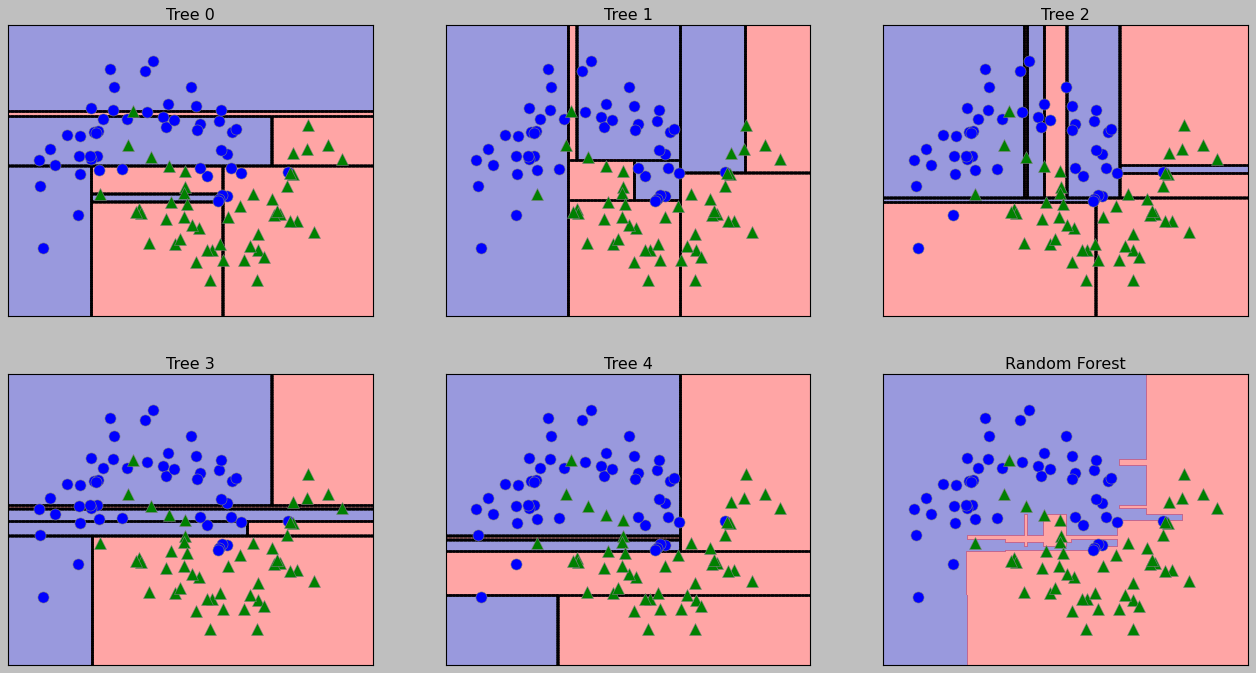

In [32]:
fig, axes = plt.subplots(2,3,figsize = (20,10))

# forest.estimators_ 의 개수가 5개 이므로 5 까지만 반복됨
for i, (ax,tree) in enumerate(zip(axes.ravel(), forest.estimators_)) : 
    ax.set_title(f"Tree {i}")
    mglearn.plots.plot_tree_partition(X,y,tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X, fill = True, ax = axes[-1,-1], alpha = 0.4)
axes[-1,-1].set_title("Random Forest")
mglearn.discrete_scatter(X[:,0], X[:,1], y)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state = 0).fit(X_train, y_train)

print(f"train score : {forest.score(X_train, y_train):0.4f}")
print(f"test score : {forest.score(X_test, y_test):0.4f}")

train score : 1.0000
test score : 0.9720


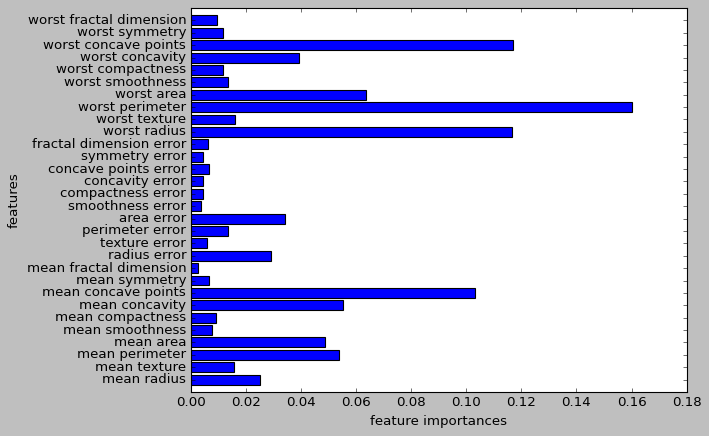

In [34]:
plot_feature_importances_cancer(forest)

### 랜덤 포레스트의 장점
#### 성능 매우 뛰어나다.
#### 결정트리를 기반으로 하므로 많은 전처리가 필요하지 않다.

### 랜덤 포레스트의 단점
#### 선형함수보다 훈련과 예측이 느리다.

# 그레이디언트 부스팅 회귀 트리
### 깊이가 얕은 트리(보통 1~5개)를 많이 사용하여 예측의 정확성을 높인다.
### learning late : 클수록 복잡하고 일반화는 약해진다.
### n_estimators : 학습하는 트리의 개수
### max_depth : 기본값 = 3, 보통 5보다 깊게 하지 않는다.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target,
                                                    random_state=0)
gbrt = GradientBoostingClassifier(random_state = 0).fit(X_train, y_train)

print(f"train score : {gbrt.score(X_train, y_train):0.4f}")
print(f"test score : {gbrt.score(X_test, y_test):0.4f}")

train score : 1.0000
test score : 0.9650


In [40]:
# 훈련 데이터의 점수가 1 이라는 것은 과대적합을 의미하므로 복잡도를 낮추고 일반화를 강화한다.
gbrt = GradientBoostingClassifier(random_state = 0, max_depth=1).fit(X_train, y_train)

print(f"train score : {gbrt.score(X_train, y_train):0.4f}")
print(f"test score : {gbrt.score(X_test, y_test):0.4f}")

train score : 0.9906
test score : 0.9720


In [42]:
gbrt = GradientBoostingClassifier(random_state = 0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print(f"train score : {gbrt.score(X_train, y_train):0.4f}")
print(f"test score : {gbrt.score(X_test, y_test):0.4f}")

train score : 0.9883
test score : 0.9650


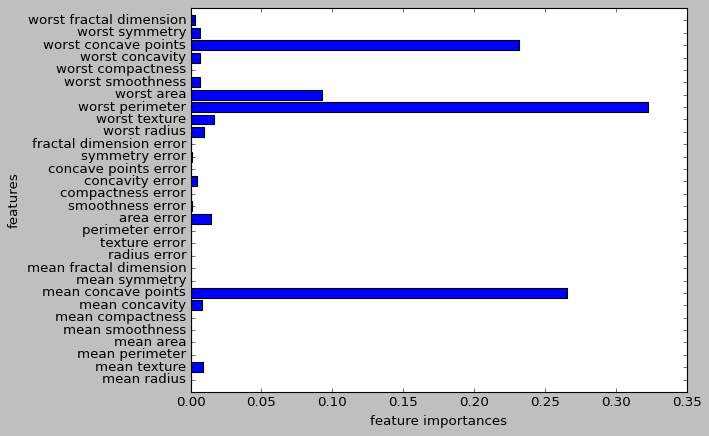

In [43]:
gbrt = GradientBoostingClassifier(random_state = 0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

### 그레이디언트 부스팅 트리 특징
#### 랜덤 포레스트에서 예측 시간이 중요하거나, 매개변수를 좀 더 튜닝하여 극한의 효율을 뽑고 싶을 때
#### 대규모 데이터라면 xgboost 라이브러리를 사용하면 보다 효율적일 수 있음
#### n_estimators 가 클수록 좋은 랜덤포레스트와 달리 그레이디언트 부스팅 트리에서 n_estimators 가 과도하게 크면 과적합 될 수 있음
#### learning late 를 낮추면 비슷한 모델을 더 많이 만들기 위해 n_estimators 가 커져야 함